# $$---: Constitution-Xpert :---$$    

## <p style="text-align: center;">This is project of Group No. 3 as a part of PGDAI course</p>
---
### `Project Description:` 
### The Constitution-Xpert project integrates advanced Natural Language Processing (NLP) methods, customized data management, and AI-driven language models to develop  a robust Question & Answer (Q&A) system that enables users to explore and understand the Constitution of India effectively

[OpenAI token limit](https://platform.openai.com/docs/models/gpt-4)  
OpenAI's embedding model has 1536 dimensions.  
After the data is turned into embeddings, they are stored in a vectorstore database, such as Pinecone, Chroma and Faiss, etc.  
Once the query is provided, the most relevant chunks of data is queried based on the similarity (semantic search)  


---
## Initial Setup

In [1]:
%%capture
!pip install openai langchain  tiktoken pypdf unstructured[local-inference] gradio watermark

In [2]:
%%capture
!pip install pinecone-client

In [3]:
import warnings
warnings.filterwarnings("ignore")
%reload_ext watermark
%watermark -a "Group No. 3 PGDAI March 2023" -vmp langchain,openai,pinecone,gradio

Author: Group No. 3 PGDAI March 2023

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.12.0

langchain: 0.0.265
openai   : 0.27.8
pinecone : 2.2.2
gradio   : 3.40.1

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 16
Architecture: 64bit



In [1]:
## necessary imports
import os
from dotenv import load_dotenv
import openai
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Pinecone
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chains import ConversationalRetrievalChain
from langchain.chat_models import ChatOpenAI

In [2]:
load_dotenv()

True

In [3]:
#Get the API key value from the environment variable
openai_api_key = os.getenv("OPENAI_API_KEY")
pinecone_api_key = os.getenv("PINECONE_API_KEY")
pinecone_env_key = os.getenv("PINECONE_ENV")

# print(openai_api_key)
# print(pinecone_api_key)
# print(pinecone_env_key)

In [4]:
os.environ['OPENAI_API_KEY'] =os.getenv("OPENAI_API_KEY")

## [LangChain Document Loader](https://python.langchain.com/en/latest/modules/indexes/document_loaders.html)

In [5]:
#loading our document
from langchain.document_loaders import DirectoryLoader
txt_loader = DirectoryLoader(os.getcwd(), glob="**/*.txt")

In [6]:
# Load up your text into documents
documents = txt_loader.load()

In [7]:
print (f'You have {len(documents)} document(s) in your data')
print (f'There are {len(documents[0].page_content)} characters in your document')

You have 2 document(s) in your data
There are 2175621 characters in your document


In [8]:
documents[0]

Document(page_content='Historical Background: The British came to India in 1600 as traders, in the form of East India Company, which had the exclusive right of trading in India under a charter granted by Queen Elizabeth I. In 1765, the Company, which till now had purely trading functions obtained the ‘diwani’ (i.e., rights over revenue and civil justice) of Bengal, Bihar and Orissa.1 This started its career as a territorial power. In 1858, in the wake of the ‘sepoy mutiny’, the British Crown assumed direct responsibility for the governance of India. This rule continued until India was granted independence on August 15, 1947.\n\nWith Independence came the need for a Constitution. Hence, a Constituent Assembly was formed for this purpose in 1946 and on January 26, 1950, the Constitution came into being. However, various features of the Indian Constitution and polity have their roots in the British rule. There were certain events in the British rule that laid down the legal framework for 

In [29]:
documents[1];

---
## Split the Text from the documents to create chunks

In [10]:
text_splitter = CharacterTextSplitter(chunk_size=2000, chunk_overlap=500) #chunk overlap seems to work better
documents = text_splitter.split_documents(documents)
print(len(documents)) ## The entire document is split into 1780 chunks

1780


In [11]:
documents[0] ##first chunk of our data

Document(page_content='Historical Background: The British came to India in 1600 as traders, in the form of East India Company, which had the exclusive right of trading in India under a charter granted by Queen Elizabeth I. In 1765, the Company, which till now had purely trading functions obtained the ‘diwani’ (i.e., rights over revenue and civil justice) of Bengal, Bihar and Orissa.1 This started its career as a territorial power. In 1858, in the wake of the ‘sepoy mutiny’, the British Crown assumed direct responsibility for the governance of India. This rule continued until India was granted independence on August 15, 1947.\n\nWith Independence came the need for a Constitution. Hence, a Constituent Assembly was formed for this purpose in 1946 and on January 26, 1950, the Constitution came into being. However, various features of the Indian Constitution and polity have their roots in the British rule. There were certain events in the British rule that laid down the legal framework for 

In [30]:
documents[1000] ##1000th chunk of our data

Document(page_content='Ceiling on Cash Donations Lowered: In 2017 budget, the limit for anonymous cash donations by any individual to a political party has been lowered from Rs. 20,000 to Rs. 2,000. This means that now the political parties cannot receive more than Rs. 2,000 as cash donations. However, they are not required to inform the Election Commission of India the details of persons who donate under Rs. 2,000. They must keep records of persons making above Rs. 2,000 donations.\n\nCap on Corporate Contributions Lifted: In 2017 budget, the limit on corporate contributions from 7.5 per cent of the net profit of a company’s past three financial years has been removed. This means that now a company can donate any amount of money to any political party. Further, the obligation of the company to report such donations in its profit and loss account has also been lifted.', metadata={'source': 'C:\\Users\\APURV\\DAI_Project\\Constitution-Xpert using OpenAI Embeddings\\Final_dai_preject_29\

---
## Embeddings and storing it in vectorestore i.e. creating knowledge base

In [13]:
# Turn our texts into embeddings
embeddings = OpenAIEmbeddings()

### Using pinecone for storing vectors embeddings

### Resources:
- [Pinecone langchain doc](https://python.langchain.com/en/latest/modules/indexes/vectorstores/examples/pinecone.html?highlight=pinecone#pinecone
)
- What is [vectorstore](https://www.pinecone.io/learn/vector-database/)
- Get your pinecone api key and env -> https://app.pinecone.io/

In [15]:
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
PINECONE_ENV = os.getenv("PINECONE_ENV")

In [16]:
# # Run this block of code when you need to create new vector embeddings for the first time

# import pinecone 

# # initialize pinecone
# pinecone.init(
#     api_key=PINECONE_API_KEY,  # find at app.pinecone.io
#     environment=PINECONE_ENV  # next to api key in console
# )

# index_name = "langchain-index" ## Mention your pinecone index name

# vectorstore = Pinecone.from_documents(documents, embeddings, index_name=index_name)

In [17]:
## Run this block of code  if you want to use existing vector embeddings, you can load it like this

import pinecone
from tqdm.autonotebook import tqdm

# initialize pinecone
pinecone.init(
    api_key=PINECONE_API_KEY,  # find at app.pinecone.io
    environment=PINECONE_ENV  # it can be found next to api key in console
)

index_name = "langchain-index" # mention your index name here
vectorstore = Pinecone.from_existing_index(index_name, embeddings) ## fetching our existing vector embeddings

C:\Users\APURV\anaconda3\lib\site-packages\pinecone\index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


---
## Testing our system 

In [18]:
query = "Writs in constitution"
docs = vectorstore.similarity_search(query)

In [19]:
len(docs) #the system found out 4 different vectors which have similarity related to entered query

4

In [20]:
print(docs[0].page_content)

Writs in the Constitution: Following are different writs in the constitution Habeas Corpus: It is Latin term which literally means ‘to have the body of’. It is an order issued by the court to a person who has detained another person to produce the body of latter before it. The court then examines the cause and legality of the detention. It would set the detained person free, if the detention is found to be illegal. Thus writ is a bulwark of individual liberty against arbitrary detention. The writ of Habeas Corpus can issued against both public and private person. However it cannot be issued in following cases:- 1. Detention is lawful. 2. Proceeding is for contempt of legislation or a court. 3. Detention is by a competent court. 4. Detention is outside the jurisdiction of the court.

Mandamus: It literally means ‘we command’. It is command issued by the court to a public official asking him to perform his official duties that he has failed or refused to perform. It can also be issued ag

In [21]:
print(docs[1].page_content)

Writs in the Constitution: Following are different writs in the constitution Habeas Corpus: It is Latin term which literally means ‘to have the body of’. It is an order issued by the court to a person who has detained another person to produce the body of latter before it. The court then examines the cause and legality of the detention. It would set the detained person free, if the detention is found to be illegal. Thus writ is a bulwark of individual liberty against arbitrary detention. The writ of Habeas Corpus can issued against both public and private person. However it cannot be issued in following cases:- 1. Detention is lawful. 2. Proceeding is for contempt of legislation or a court. 3. Detention is by a competent court. 4. Detention is outside the jurisdiction of the court.


---
## Now the langchain part (Chaining with Chat History) --> `Adding Memory` to our system

In [22]:
from langchain.llms import OpenAI

In [23]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k":2})
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.5), retriever)

In [24]:
chat_history = []
query = "What are fundamental rights"
result = qa({"question": query, "chat_history": chat_history})
result["answer"]

' Fundamental rights are rights guaranteed by the Constitution of India that are meant to strike a balance between the rights of individuals and those of society as a whole. They are available to citizens and non-citizens alike, and include the right to equality, freedom, against exploitation, freedom of religion, cultural and educational rights, and the right to constitutional remedies. Originally, there were seven fundamental rights, but the right to property was removed by the 44th Amendment Act, 1978.'

In [25]:
chat_history.append((query, result["answer"]))
chat_history

[('What are fundamental rights',
  ' Fundamental rights are rights guaranteed by the Constitution of India that are meant to strike a balance between the rights of individuals and those of society as a whole. They are available to citizens and non-citizens alike, and include the right to equality, freedom, against exploitation, freedom of religion, cultural and educational rights, and the right to constitutional remedies. Originally, there were seven fundamental rights, but the right to property was removed by the 44th Amendment Act, 1978.')]

In [26]:
query = "Can you tell articles related to it"
result = qa({"question": query, "chat_history": chat_history})
result["answer"]

' Articles 14-18, 19-22, 23-24, 25-28, 29-30, and 32.'

### As seen from above query we first asked our system about `Fundamental Rights` and followed up with next query to tell related articles about the same. The system responded perfectly giving accurate answer for both the query.

### This implies `our system can remember past query` and can give answer based on past user prompts 

---
## Create a chatbot having memory with simple widgets 

In [27]:
from IPython.display import display
import ipywidgets as widgets

In [30]:
chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""
    
    if query.lower() == 'exit':
        print("Thanks for the chat!")
        return
    
    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))
    
    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="Orange">Chatbot:</font></b> {result["answer"]}'))

print("Chat with your data. Type 'exit' to stop")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)

display(input_box)

Chat with your data. Type 'exit' to stop


Text(value='', placeholder='Please enter your question:')

HTML(value='<b>User:</b> what is article 1')

HTML(value='<b><font color="Orange">Chatbot:</font></b>  Article 1 of the Indian Constitution is about the Uni…

Thanks for the chat!


## Gradio to build  [chatbot like UI](https://gradio.app/docs/#chatbot)

In [31]:
import gradio as gr

# Create a UI Block using gr.Blocks()
with gr.Blocks() as demo:
    # Add a Chatbot component
    gr.Markdown("<h1> <center> Welcome to the Constitution-Xpert! 🇮🇳 </center>")
    gr.Markdown("<h1> <center> 📜📃📖✒️ ⚖️🧑🏽‍⚖️👩‍⚖️_ A one stop solution to all your queries related to Constitution of India_ ⚖️🧑🏽‍⚖️👩‍⚖️ ✒️📖📜📃 </center></h1>")
    gr.Markdown("<hr>")
    gr.Markdown("<h2>How can I assist you today?</h2>")

    chatbot = gr.Chatbot(label="Constitution-Xpert: 🕵 ",height=450)
                         
    # Add a Textbox component for user input
    msg = gr.Textbox(placeholder="Input your query and then hit the enter key",label="User: 🧑🏾‍💻 ",
                     show_label=True,show_copy_button=True)

    # Add a Button to clear the chat history
    clear = gr.Button(" Clear ⛔ ")

    # Function to respond to user messages
    def respond(user_message, chat_history):
        print(user_message)
        print(chat_history)
        
        # Convert chat_history to a list of tuples for better readability
        if chat_history:
            chat_history = [tuple(sublist) for sublist in chat_history]
            print(chat_history)

        # Get response from QA chain
        response = qa({"question": user_message, "chat_history": chat_history})
        
        # Append user message and response to chat history
        chat_history.append((user_message, response["answer"]))
        print(chat_history)
        
        return "", chat_history

    # Call the submit method to bind the respond function with UI components
    msg.submit(respond, [msg, chatbot], [msg, chatbot], queue=False)

    # Bind the Clear button to do nothing when clicked
    clear.click(lambda: None, None, chatbot, queue=False)

# Launch the UI Block with debug and sharing options
demo.launch(debug=True, share=True)

Running on local URL:  http://127.0.0.1:7860
tell me something about constitution
[]
[('tell me something about constitution', ' The Indian Constitution is the lengthiest Constitution in the world. It contains a Preamble, about 448 Articles divided into 25 Parts, and 12 Schedules. It divides the powers between the Centre and the states in terms of the Union List, State List and Concurrent List in the Seventh Schedule. The Constitution is the supreme law of the land, and its organs of the government (legislative, executive and judicial) must operate within the jurisdiction prescribed by the Constitution. Article 32 of the Indian Constitution grants a citizen the right to file a complaint with the Supreme Court to have any fundamental rights upheld in the event that they are violated. The 42nd Amendment Act, 1976, also known as the “Mini-Constitution,” made numerous amendments to the Indian Constitution. Part lll of the Indian Constitution is referred to as its Magna Carta, which is a de

what is anti-national according to country
[['tell me something about constitution', 'The Indian Constitution is the lengthiest Constitution in the world. It contains a Preamble, about 448 Articles divided into 25 Parts, and 12 Schedules. It divides the powers between the Centre and the states in terms of the Union List, State List and Concurrent List in the Seventh Schedule. The Constitution is the supreme law of the land, and its organs of the government (legislative, executive and judicial) must operate within the jurisdiction prescribed by the Constitution. Article 32 of the Indian Constitution grants a citizen the right to file a complaint with the Supreme Court to have any fundamental rights upheld in the event that they are violated. The 42nd Amendment Act, 1976, also known as the “Mini-Constitution,” made numerous amendments to the Indian Constitution. Part lll of the Indian Constitution is referred to as its Magna Carta, which is a declaration of rights.']]
[('tell me somethin

do you know about article 31f
[['tell me something about constitution', 'The Indian Constitution is the lengthiest Constitution in the world. It contains a Preamble, about 448 Articles divided into 25 Parts, and 12 Schedules. It divides the powers between the Centre and the states in terms of the Union List, State List and Concurrent List in the Seventh Schedule. The Constitution is the supreme law of the land, and its organs of the government (legislative, executive and judicial) must operate within the jurisdiction prescribed by the Constitution. Article 32 of the Indian Constitution grants a citizen the right to file a complaint with the Supreme Court to have any fundamental rights upheld in the event that they are violated. The 42nd Amendment Act, 1976, also known as the “Mini-Constitution,” made numerous amendments to the Indian Constitution. Part lll of the Indian Constitution is referred to as its Magna Carta, which is a declaration of rights.'], ['what is anti-national accordin

Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-VCYbHLJOY1JS2zIDm3ygE9J2 on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-VCYbHLJOY1JS2zIDm3ygE9J2 on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/acco

[('tell me something about constitution', 'The Indian Constitution is the lengthiest Constitution in the world. It contains a Preamble, about 448 Articles divided into 25 Parts, and 12 Schedules. It divides the powers between the Centre and the states in terms of the Union List, State List and Concurrent List in the Seventh Schedule. The Constitution is the supreme law of the land, and its organs of the government (legislative, executive and judicial) must operate within the jurisdiction prescribed by the Constitution. Article 32 of the Indian Constitution grants a citizen the right to file a complaint with the Supreme Court to have any fundamental rights upheld in the event that they are violated. The 42nd Amendment Act, 1976, also known as the “Mini-Constitution,” made numerous amendments to the Indian Constitution. Part lll of the Indian Constitution is referred to as its Magna Carta, which is a declaration of rights.'), ('what is anti-national according to country', 'According to t

Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-VCYbHLJOY1JS2zIDm3ygE9J2 on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-VCYbHLJOY1JS2zIDm3ygE9J2 on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/acco

[('tell me something about constitution', 'The Indian Constitution is the lengthiest Constitution in the world. It contains a Preamble, about 448 Articles divided into 25 Parts, and 12 Schedules. It divides the powers between the Centre and the states in terms of the Union List, State List and Concurrent List in the Seventh Schedule. The Constitution is the supreme law of the land, and its organs of the government (legislative, executive and judicial) must operate within the jurisdiction prescribed by the Constitution. Article 32 of the Indian Constitution grants a citizen the right to file a complaint with the Supreme Court to have any fundamental rights upheld in the event that they are violated. The 42nd Amendment Act, 1976, also known as the “Mini-Constitution,” made numerous amendments to the Indian Constitution. Part lll of the Indian Constitution is referred to as its Magna Carta, which is a declaration of rights.'), ('what is anti-national according to country', 'According to t

Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-VCYbHLJOY1JS2zIDm3ygE9J2 on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-VCYbHLJOY1JS2zIDm3ygE9J2 on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/acco

[('tell me something about constitution', 'The Indian Constitution is the lengthiest Constitution in the world. It contains a Preamble, about 448 Articles divided into 25 Parts, and 12 Schedules. It divides the powers between the Centre and the states in terms of the Union List, State List and Concurrent List in the Seventh Schedule. The Constitution is the supreme law of the land, and its organs of the government (legislative, executive and judicial) must operate within the jurisdiction prescribed by the Constitution. Article 32 of the Indian Constitution grants a citizen the right to file a complaint with the Supreme Court to have any fundamental rights upheld in the event that they are violated. The 42nd Amendment Act, 1976, also known as the “Mini-Constitution,” made numerous amendments to the Indian Constitution. Part lll of the Indian Constitution is referred to as its Magna Carta, which is a declaration of rights.'), ('what is anti-national according to country', 'According to t

Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-VCYbHLJOY1JS2zIDm3ygE9J2 on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-VCYbHLJOY1JS2zIDm3ygE9J2 on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/acco

[('tell me something about constitution', 'The Indian Constitution is the lengthiest Constitution in the world. It contains a Preamble, about 448 Articles divided into 25 Parts, and 12 Schedules. It divides the powers between the Centre and the states in terms of the Union List, State List and Concurrent List in the Seventh Schedule. The Constitution is the supreme law of the land, and its organs of the government (legislative, executive and judicial) must operate within the jurisdiction prescribed by the Constitution. Article 32 of the Indian Constitution grants a citizen the right to file a complaint with the Supreme Court to have any fundamental rights upheld in the event that they are violated. The 42nd Amendment Act, 1976, also known as the “Mini-Constitution,” made numerous amendments to the Indian Constitution. Part lll of the Indian Constitution is referred to as its Magna Carta, which is a declaration of rights.'), ('what is anti-national according to country', 'According to t

---
## Sample output
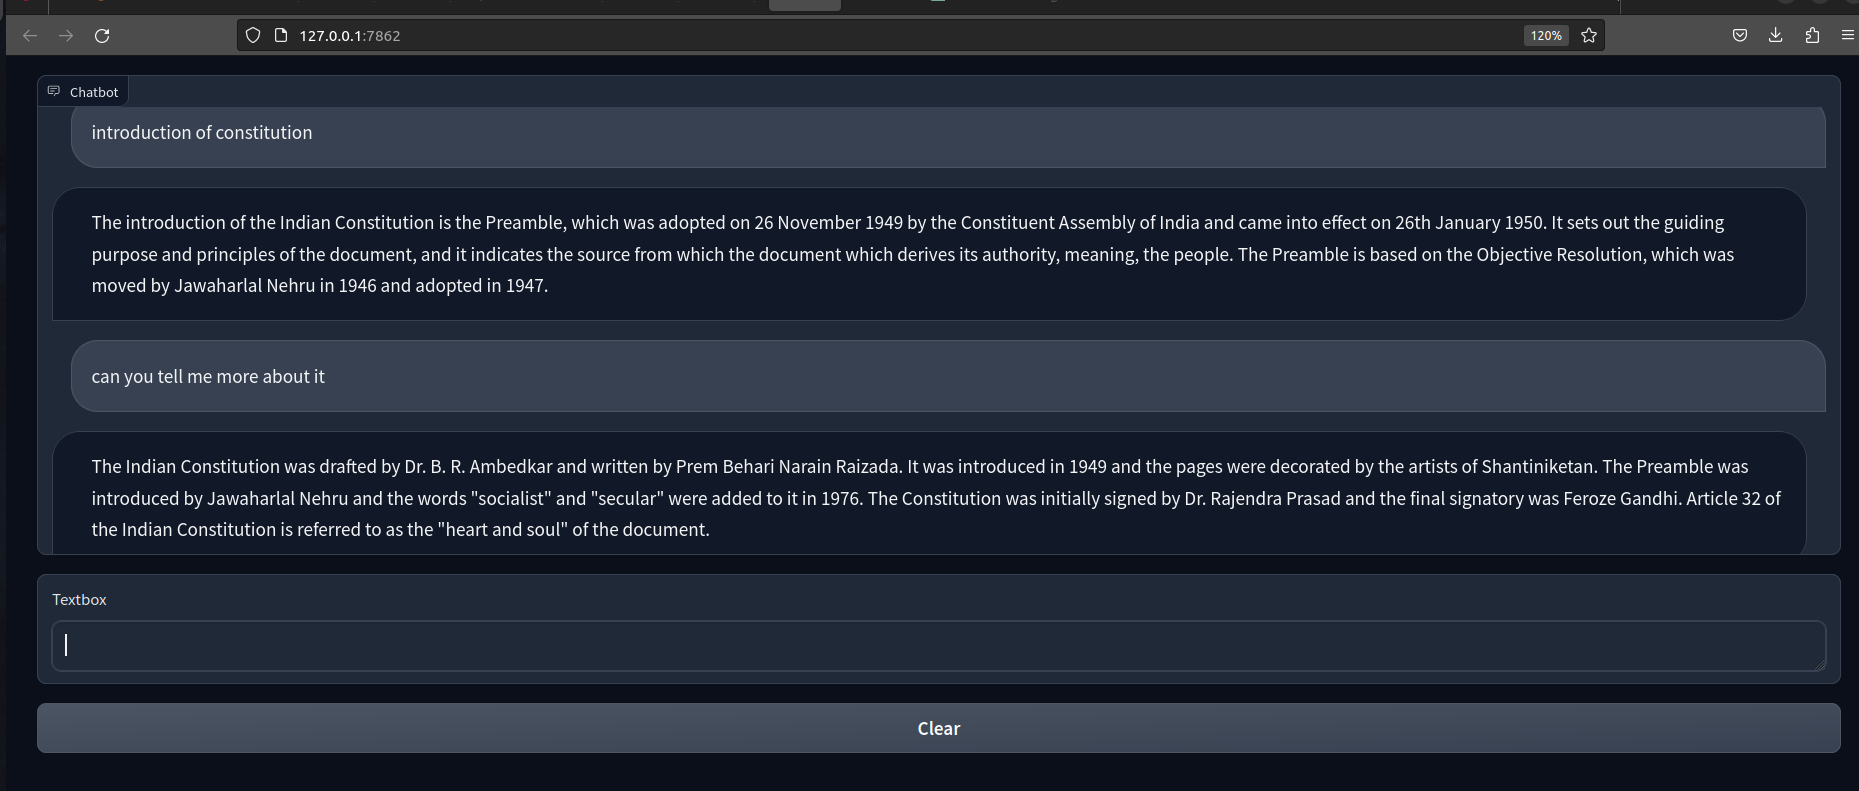

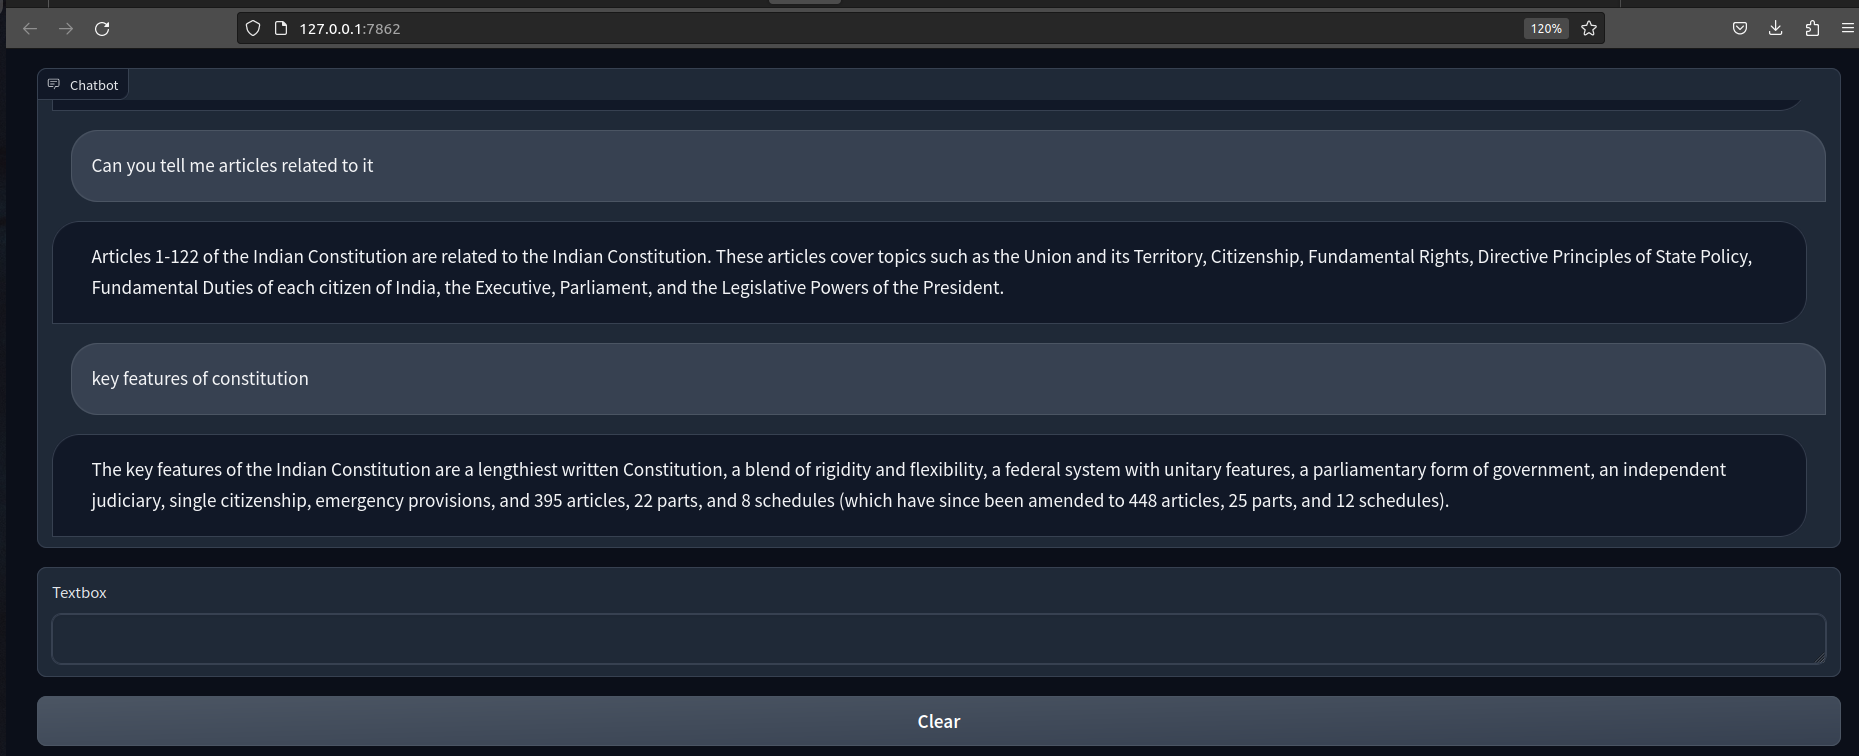

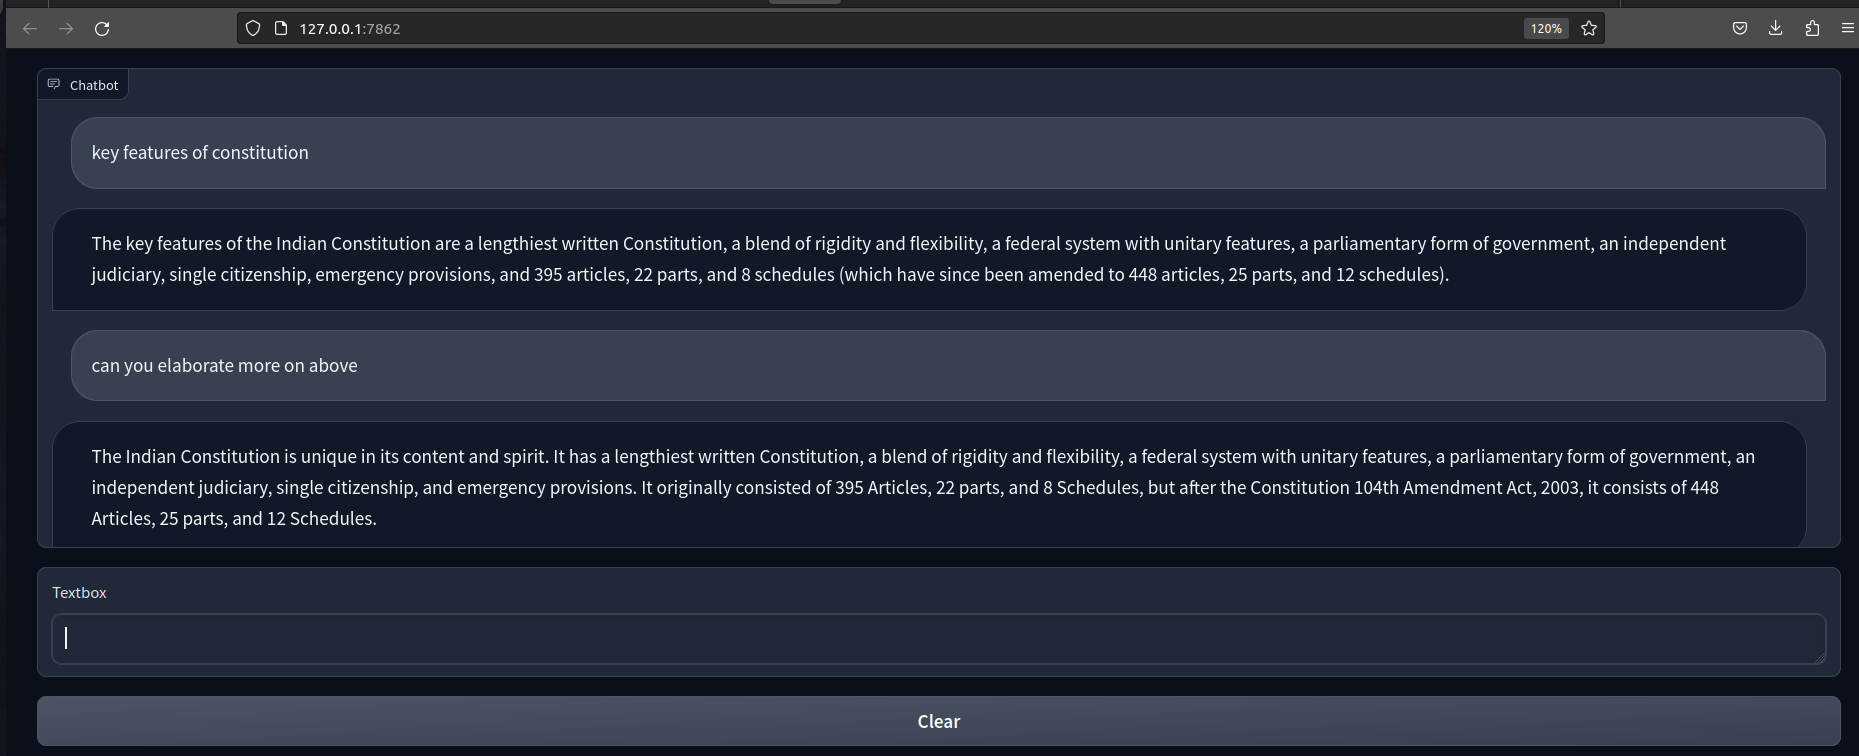

## The system answers only on custom data on which it is trained

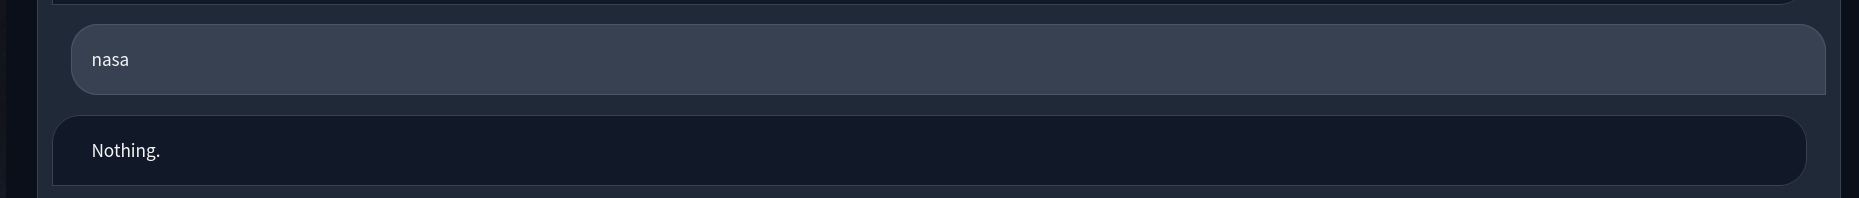
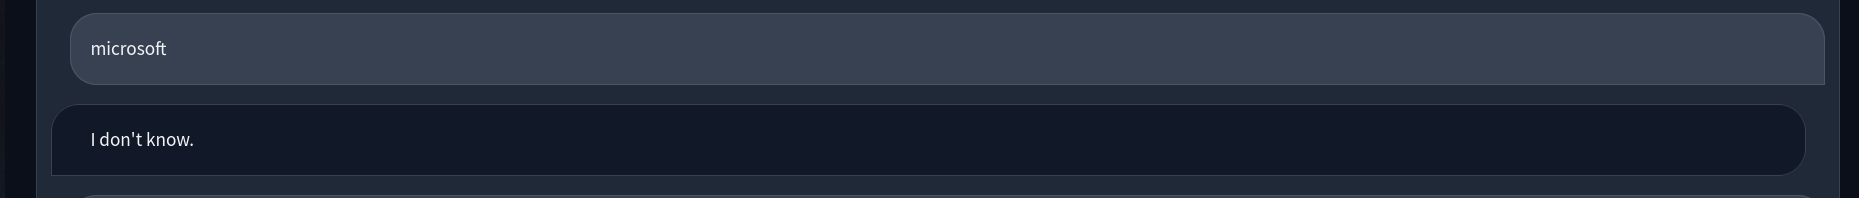

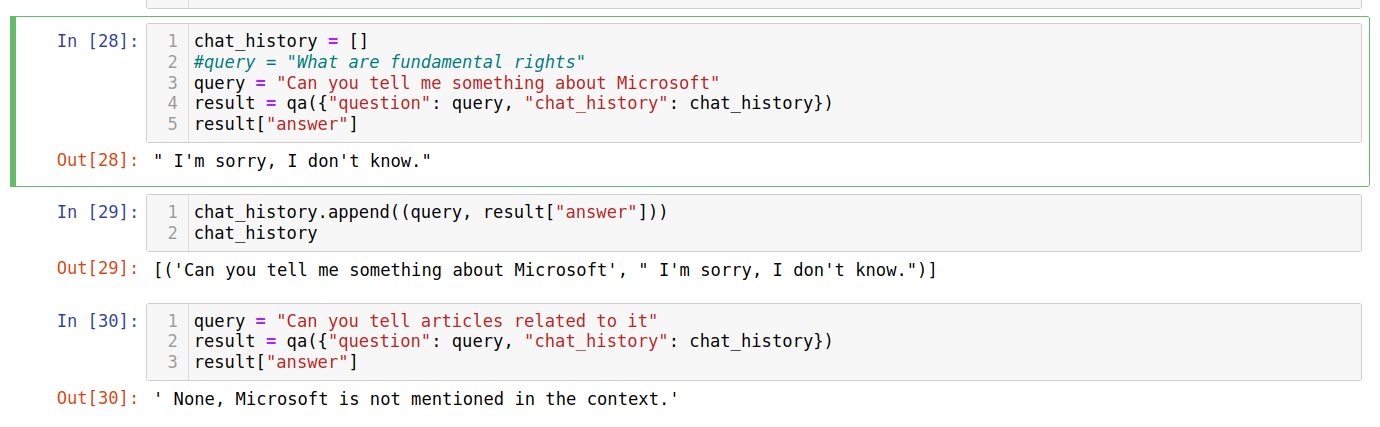

## $$ *********** $$